In [1]:
# !pip install alibi_detect
# !pip install alibi-detect[tensorflow]

In [2]:
import os 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 

from PIL import Image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [3]:
test_directory = './carpet/test/'
bad_folders = [folder for folder in os.listdir(test_directory) if folder != 'good']

idx = 0
for bad_folder in bad_folders:
    bad_images = os.listdir(test_directory + bad_folder + '/')
    for image_path in bad_images:
        if (image_path.split('.')[1] == 'png'):
            image = cv2.imread(test_directory + bad_folder + '/' + image_path)
            cv2.imwrite(f'./carpet/train/bad/{idx}.png', image)
            idx += 1

In [4]:
image_directory = './carpet/train/'
SIZE = 64
dataset = []

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        
dataset = np.array(dataset)

train, test = dataset[0:250], dataset[250:280]
train = train.astype('float32')/ 255
test = test.astype('float32') / 255

bad_images = os.listdir(image_directory + 'bad/')
bad_dataset = []

for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))

bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255

print(train.shape, test.shape, bad_dataset.shape)

(250, 64, 64, 3) (30, 64, 64, 3) (89, 64, 64, 3)


In [5]:
encoding_dim = 1024 
dense_dim = [8, 8, 512]

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=train[0].shape),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
    Flatten(),
    Dense(encoding_dim)
])

print(encoder_net.summary())

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(encoding_dim, )),
    Dense(np.prod(dense_dim)),
    Reshape(target_shape=dense_dim),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

print(decoder_net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________

In [6]:
latent_dim = 1024 

od = OutlierVAE(
    threshold=0.015,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
    samples=4
)

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
od.fit(train, optimizer=adam, epochs=20, batch_size=4, verbose=True)

63/63 [=] - 35s 558ms/step - loss_ma: -19972.3592


In [7]:
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print('Current threshold value is: ', od.threshold)

Current threshold value is:  0.0031451940606348223


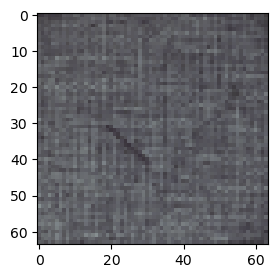

In [8]:
img_num = 9
test_bad_img = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.figure(figsize=(4, 3))
plt.imshow(test_bad_img[0])
plt.show()

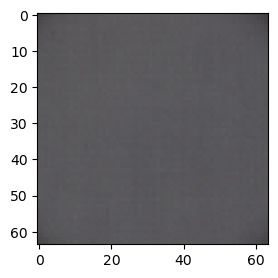

In [9]:
test_bad_img_recon = od.vae(test_bad_img)
test_bad_img_recon = test_bad_img_recon.numpy()
plt.figure(figsize=(4, 3))
plt.imshow(test_bad_img_recon[0])
plt.show()

In [10]:
test_bad_img_predict = od.predict(test_bad_img)
bad_img_instance_score = test_bad_img_predict['data']['instance_score'][0]
print('The instance score is:', bad_img_instance_score)

The instance score is: 0.0024982586


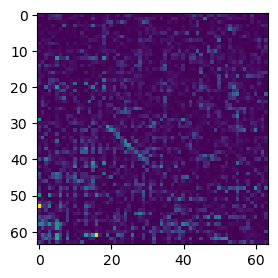

Is this image an outlier (0 for NO and 1 for YES)? 0


In [11]:
bad_img_feature_score = test_bad_img_predict['data']['feature_score'][0]
plt.figure(figsize=(4, 3))
plt.imshow(bad_img_feature_score[:, :, 0])
plt.show()
print('Is this image an outlier (0 for NO and 1 for YES)?', test_bad_img_predict['data']['is_outlier'][0])

In [12]:
X = bad_dataset[:60]
od_preds = od.predict(X, outlier_type='instance', outlier_perc=30, return_feature_score=True, return_instance_score=True)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


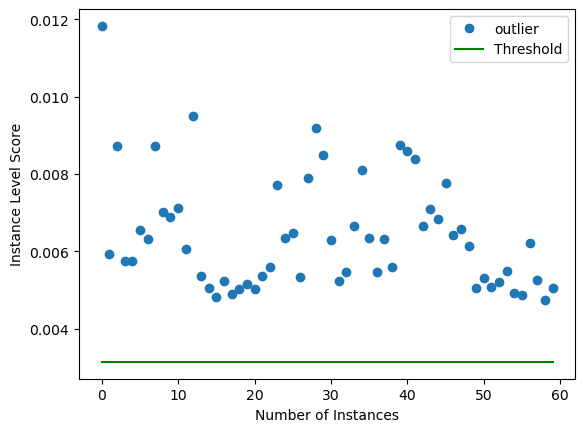

In [13]:
target = np.ones(X.shape[0], ).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

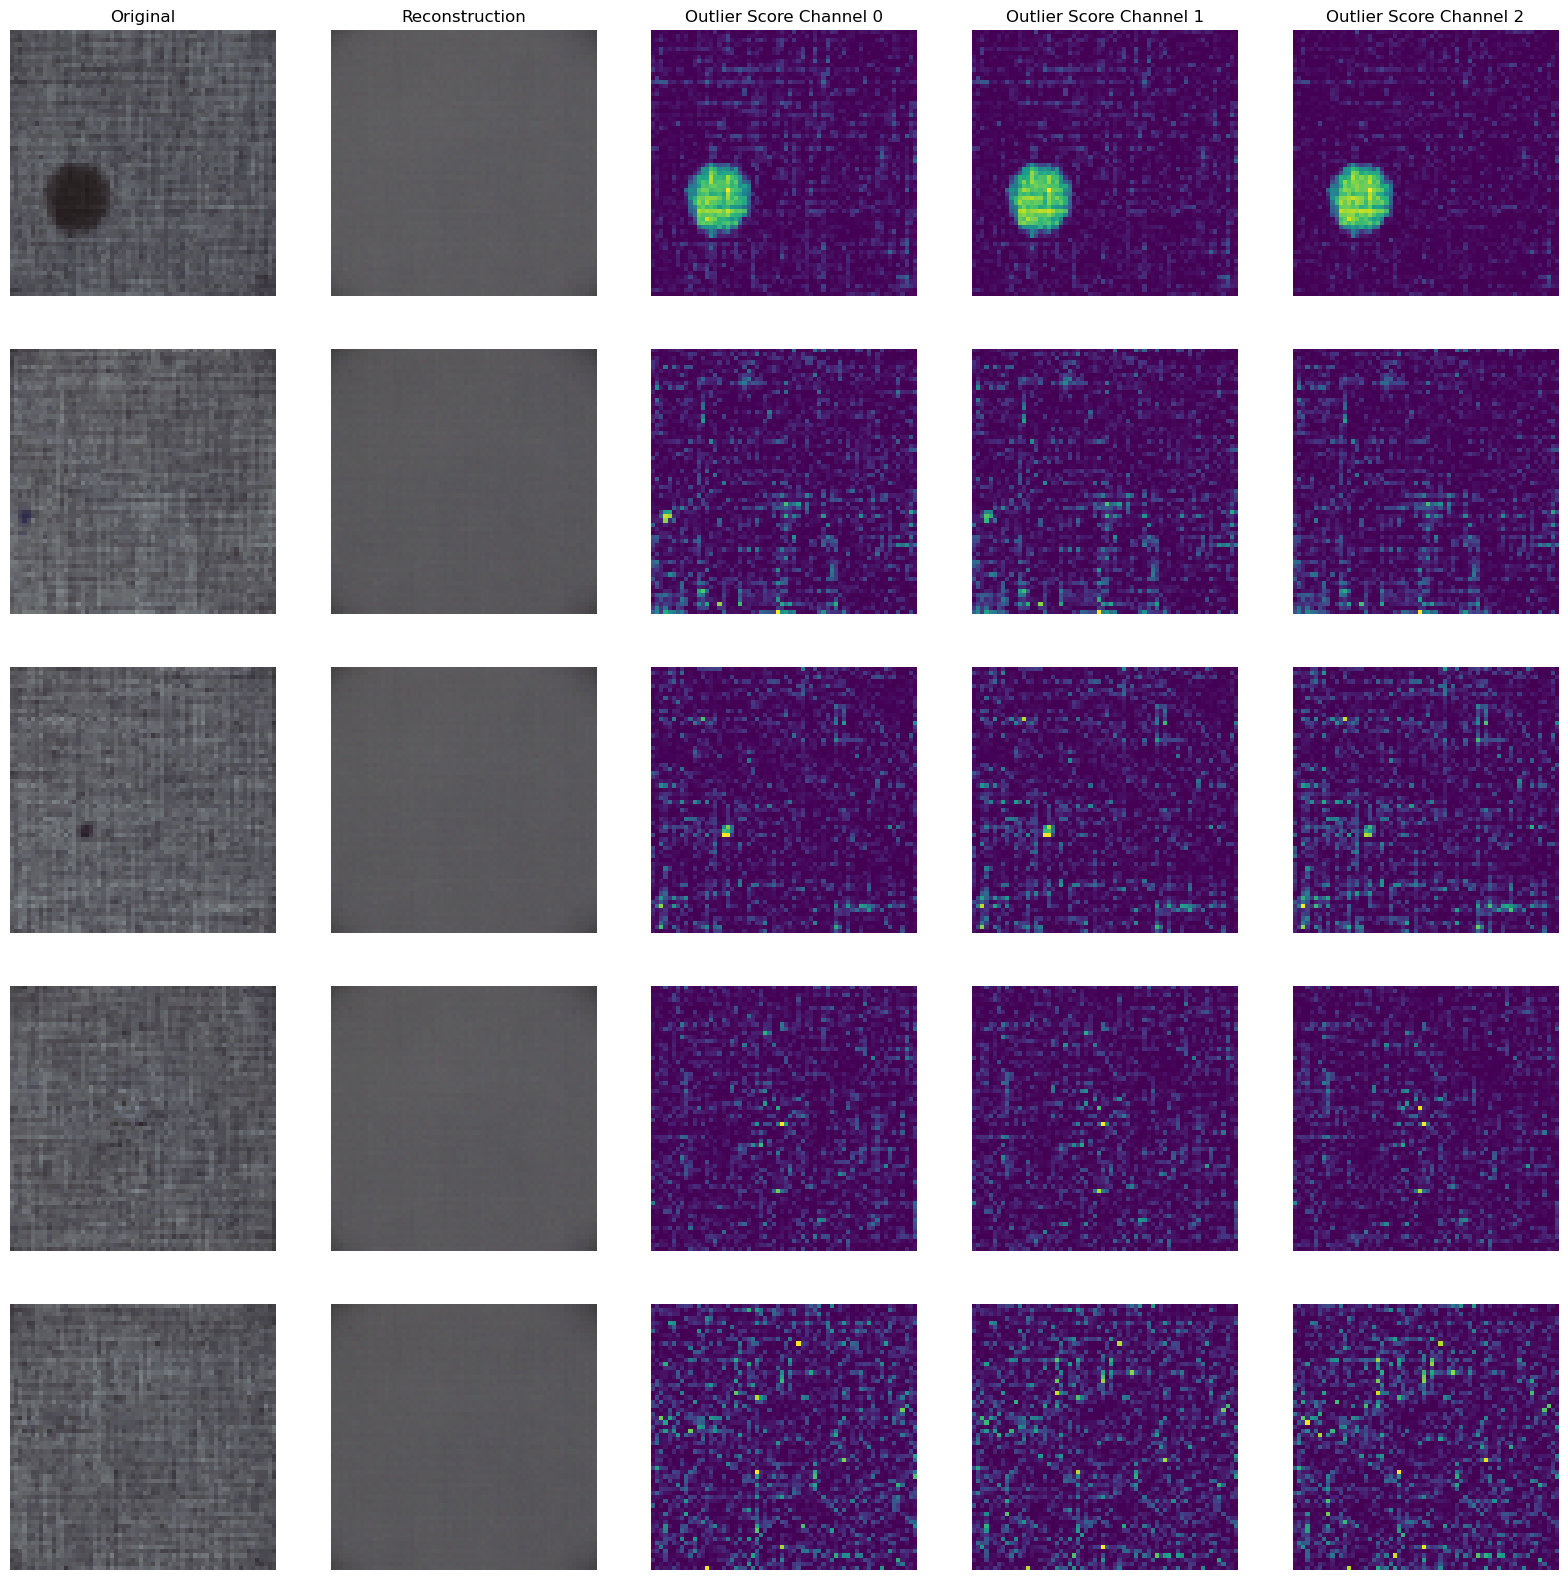

In [14]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds, X, X_recon=X_recon, instance_ids=[0, 5, 10, 15, 20], max_instances=5, outliers_only=False)